In [58]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
import numpy as np
import random

In [2]:
import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util

Loading chipmunk for Linux (64bit) [/home/arnav/anaconda3/envs/geo_env/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [3]:
def setup_space(gx, gy, damping):
    space = pymunk.Space()
    space.gravity = gx, gy
    space.damping = damping
    return space

In [4]:
def setup_walls(space, px, py, offset, elasts, width):
    body = pymunk.Body(body_type = pymunk.Body.STATIC) # 1
    body.position = (px, py)
    offset = offset
    l1 = pymunk.Segment(body, (-offset, offset), (offset, offset), width) # 2
    l2 = pymunk.Segment(body, (-offset, offset), (-offset, -offset), width)
    l3 = pymunk.Segment(body, (-offset, -offset), (offset, -offset), width)
    l4 = pymunk.Segment(body, (offset, offset), (offset, -offset), width)
    static_lines = [l1,l2,l3,l4]
    for l_idx, line in enumerate(static_lines):
        line.elasticity = elasts[l_idx]
        line.friction = 0
    space.add(static_lines) # 3
    return static_lines

In [5]:
def setup_balls(space, px, py, offset, masses, radiuses, elasts):
    width = offset*2
    height = offset*2
    balls = [ ]
    n_balls = len(radiuses)
    step = 400//n_balls + 1
    for b_idx, x in enumerate(range(-200,200,step)):
        x += width / 2
        offset_y = height
        mass = masses[b_idx]
        radius = radiuses[b_idx]
        moment = pymunk.moment_for_circle(mass, 0, radius, (0,0))
        body = pymunk.Body(mass, moment)
        body.position = x, -125+offset_y
        body.start_position = Vec2d(body.position)
        shape = pymunk.Circle(body, radius, (0,0))
        shape.elasticity = elasts[b_idx]
        space.add(body, shape)
        balls.append(body)
    #pj = pymunk.PinJoint(balls[0],balls[1], (0, 0), (0,0))
    #space.add(pj)
    #pj = pymunk.PinJoint(balls[1],balls[2], (0, 0), (0,0))
    #space.add(pj)
    return balls

In [6]:
def get_attributes(shape):
    x1, x2, y1, y2 = shape.bb.left, shape.bb.right, shape.bb.bottom, shape.bb.top
    body_type = shape.body.body_type
    if isinstance(shape, pymunk.shapes.Segment):
        shape_type = 0
    elif isinstance(shape, pymunk.shapes.Circle):
        shape_type = 1
    mass = shape.body.mass
    elasticity = shape.elasticity
    return [x1, y1, x2, y2, shape_type, body_type, mass, elasticity]

In [7]:
def initialize_params(n_balls = 5):
    gx, gy = np.random.normal()*1000, np.random.normal()*1000
    offset = np.random.choice([250,275,300,325])
    damping = np.random.rand()
    wall_elasts = np.clip(np.random.rand(4)+0.5, a_min=0.5, a_max=1)
    ball_elasts = np.clip(np.random.rand(n_balls)+0.5, a_min=0.5, a_max=1)
    radiuses = np.clip(np.random.rand(n_balls)*100, a_min=30, a_max=50)
    masses = np.clip(np.random.rand(n_balls)*40, a_min=10, a_max=40)
    params = {'gx': gx, 'gy': gy,'offset' : offset,
              'damping': damping, 'wall_elasts': wall_elasts,
              'masses': masses,'ball_elasts': ball_elasts, 'radiuses': radiuses}
    return params

In [8]:
def run_simulation(params, render=False):
    px, py = 300, 300
    buffer = 15
    side = params["offset"] + buffer
    width = 2
    if render:
        fig, ax = plt.subplots()
        plt.axis('off')
        camera = Camera(fig)
        ax.set_xlim((px-side-10, px+side+10))
        ax.set_ylim((py-side-10, py+side+10))
        ax.set_aspect("equal")
        o = pymunk.matplotlib_util.DrawOptions(ax)
    # creating objects
    space = setup_space(params["gx"], params["gy"], params["damping"])
    lines = setup_walls(space, px, py, side, params["wall_elasts"], width)
    balls = setup_balls(space, px, py, params["offset"], params["masses"], 
                        params["radiuses"], params["ball_elasts"])
    for shape in space.shapes:
        if shape.body.body_type == 0:
            fx, fy = np.random.normal(size=2)
            scale = np.random.rand()*100000
            shape.body.apply_impulse_at_local_point((fx*scale,fy*scale))
    # simulation
    total_steps = 80
    attributes = np.zeros((total_steps+2, len(space.shapes), 8))
    for i in range(total_steps+2):
        for x in range(10):
            space.step(1/50/10/2)
        for s_idx, shape in enumerate(space.shapes):
            attributes[i, s_idx] = get_attributes(shape) 
        if render:
            space.debug_draw(o)
            camera.snap()
    attributes[np.isposinf(attributes)] = 1e+8
    speed = np.diff(attributes[:,:,:2], axis=0)
    attr_spd = np.concatenate((speed, attributes[1:]), axis=-1)
    X = attr_spd[:-1,:,:7]
    y = attr_spd[1:,:,:2]
    # return output
    if render:
        anim = camera.animate()
        return X, y, anim
    else:
        return X, y

In [179]:
params = initialize_params(5)

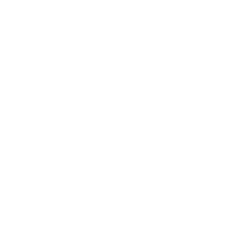

In [180]:
X, y, anim = run_simulation(params, render=True)

In [38]:
params

{'gx': -354.25645886553343,
 'gy': 1451.7669499324395,
 'offset': 250,
 'damping': 0.6506712607152207,
 'wall_elasts': array([1.        , 1.        , 0.84674737, 0.94377738]),
 'masses': array([18.41005929, 10.        ]),
 'ball_elasts': array([1., 1.]),
 'radiuses': array([36.74505545, 30.        ])}

In [11]:
HTML(anim.to_html5_video()) #.save('../data/animation.mp4')

In [174]:
def visualizer(X, history=False, t_range=3):
    '''
    Visualizes the balls in the environment.

            Parameters:
                    X (numpy.ndarray): Input of shape (time_steps, objects, features)
                    history (bool): Want historical traces or not
                    t_range (int): Number of time steps back we want to see

            Returns:
                    animation (matplotlib.animation.ArtistAnimation): Animation object which can be displayed/saved
    '''
    
    assert t_range >= 0
    
    if t_range == 0:
        history=False
    
    # setting the context
    lim_x_left = np.ravel(X[:, :, 2]).min()
    lim_x_right = np.ravel(X[:, :, 4]).max()
    lim_y_bottom = np.ravel(X[:, :, 3]).min()
    lim_y_top = np.ravel(X[:, :, 5]).max()
    fig, ax = plt.subplots()
    plt.axis('off')
    camera = Camera(fig)
    ax.set_xlim((lim_x_left, lim_x_right))
    ax.set_ylim((lim_y_bottom, lim_y_top))
    ax.set_aspect("equal")

    # setting up the agents
    duration, n_balls, _ = X[:,4:,:].shape
    
    radii = []
    for ball in range(n_balls): # look to the first ball to get the radius
        radius = X[0, 4+ball, 2:6]
        radius = 0.25 * (radius[2] - radius[0] + radius[3] - radius[1])
        radii.append(radius)
    
    if history:
        start = t_range + 1
    else:
        start = 0
        
    # drawing the balls, start from time 5
    for t in range(start, duration):
        
        # draw the walls
        ax.axvline(x=lim_x_left, c='black')
        ax.axvline(x=lim_x_right, c='black')
        ax.axhline(y=lim_y_top, c='black')
        ax.axhline(y=lim_y_bottom, c='black')
        
        colors = iter(cm.rainbow(np.linspace(0, 1, n_balls)))
        
        for ball in range(n_balls):

            pos = X[t, 4+ball, [2, 3]]
            radius = radii[ball]
            color = next(colors)
            c = plt.Circle((pos[0]+radius, pos[1]+radius), radius, color=color, clip_on=False)

            ax.add_artist(c)
            
            if history:
                
                for his in range(t_range):
                    
                    pos = X[t-1-his, 4+ball, [2, 3]]
                    radius = radii[ball]
                    color[3] = 1. - ((his+1)/(t_range+1)) # adding fade
                    c = plt.Circle((pos[0]+radius, pos[1]+radius), radius, color=color, clip_on=False)

                    ax.add_artist(c)

        camera.snap()
    
    animation = camera.animate()
    
    return animation

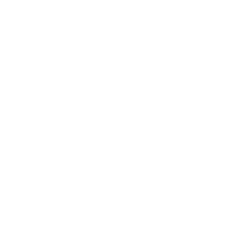

In [183]:
anim = visualizer(X, history=True, t_range=2)

In [184]:
HTML(anim.to_html5_video())